In [1]:
from fastai.vision.all import *
import fastai
import timm
import pandas as pd

In [2]:
import torch
torch.cuda.set_device(2)

In [3]:
df = pd.read_csv('data/wheat_new.csv',decimal=',')

In [4]:
df

,Unnamed: 0,file,DAS,plot nº,photo nº,species,water_treatment,management,plot m2,avg_water (L m-2),...,P (kg microplot-1),K (kg microplot-1),avg_height,GA,GGA,CSI,NGRDIveg,TGIveg,final yield (kg),dataset
0,0,20220517_1 (1).JPG,96,1,(1).,wheat,ww,conv,12,3096.2375,...,0.072,0.072,46.9715,0.959407,0.904393,5.734098,0.1324,2569.2709,9.15,train
1,1,20220517_1 (2).JPG,96,1,(2).,wheat,ww,conv,12,3096.2375,...,0.072,0.072,46.9715,0.963030,0.905523,5.971505,0.1316,2648.0105,9.15,train
2,2,20220517_1 (3).JPG,96,1,(3).,wheat,ww,conv,12,3096.2375,...,0.072,0.072,46.9715,0.953708,0.898722,5.765430,0.1331,2736.4337,9.15,train
3,3,20220517_1 (4).JPG,96,1,(4).,wheat,ww,conv,12,3096.2375,...,0.072,0.072,46.9715,0.957117,0.898772,6.095965,0.1267,2550.8238,9.15,train
4,4,20220602_1 (1).JPG,112,1,(1).,wheat,ww,conv,12,3096.2375,...,0.072,0.072,46.9715,0.892348,0.791199,11.335180,0.1008,1880.2128,9.15,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,251,20220615_25 (4).JPG,125,25,(4).,wheat,d,conv,12,2752.8000,...,0.072,0.072,55.2110,0.788544,0.323428,58.984136,0.0491,2277.6824,7.95,test
252,252,20220701_25 (1).JPG,141,25,(1).,wheat,d,conv,12,2752.8000,...,0.072,0.072,55.2110,0.031868,0.009072,71.532905,0.0342,946.1760,7.95,test
253,253,20220701_25 (2).JPG,141,25,(2).,wheat,d,conv,12,2752.8000,...,0.072,0.072,55.2110,0.025828,0.006849,73.483356,0.0314,867.4491,7.95,test
254,254,20220701_25 (3).JPG,141,25,(3).,wheat,d,conv,12,2752.8000,...,0.072,0.072,55.2110,0.022065,0.004773,78.367629,0.0196,855.3556,7.95,test


In [5]:
dftrain = df[(df.dataset=='train')|(df.dataset=='validation')]
dftrain.loc[:,'dataset'] =  dftrain['dataset'].apply(lambda x: x=='validation')
df.loc[:,'dataset'] =  df['dataset'].apply(lambda x: x=='test')

In [6]:
dftrain[dftrain.dataset==False]['final yield (kg)'].describe()

count    160.00000
mean       5.30269
std        3.88292
min        0.85790
25%        1.62280
50%        5.39235
75%        8.75000
max       10.55000
Name: final yield (kg), dtype: float64

In [7]:
dftrain.loc[:,'final yield (kg)'] = dftrain['final yield (kg)'].apply(lambda x : (x - 5.30269)/3.88292)
df.loc[:,'final yield (kg)'] = df['final yield (kg)'].apply(lambda x : (x - 5.30269)/3.88292)

In [8]:
db = DataBlock(blocks = (ImageBlock, RegressionBlock()),
                 get_x=[ColReader('file',pref='wheat_all/')],
                 get_y=[ColReader('final yield (kg)')],
                 splitter=ColSplitter(col='dataset'),    
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=384,flip_vert=True,
                                            max_zoom=1.0), Normalize.from_stats(*imagenet_stats)])
dls = db.dataloaders(dftrain,bs=8)

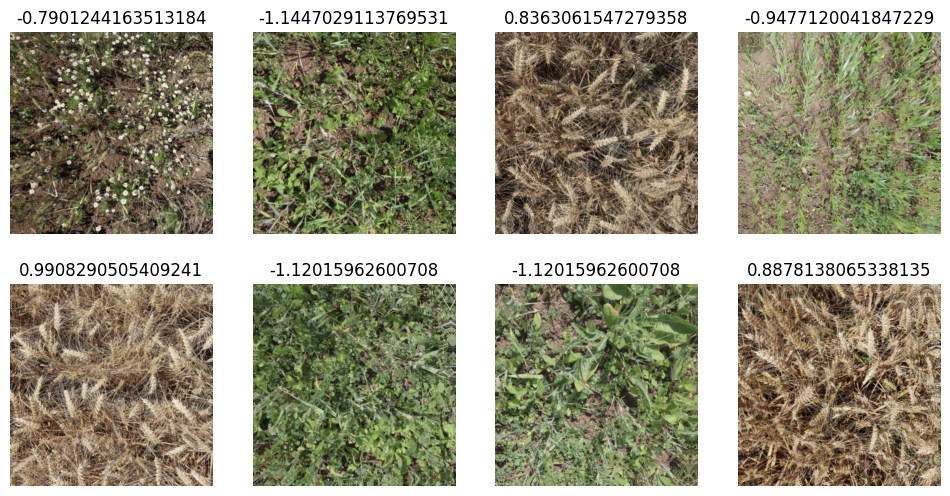

In [9]:
dls.show_batch()

In [10]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    # EarlyStoppingCallback(patience=5),
    SaveModelCallback(fname='swinv2_cr_base_384_std_yield')
]

In [11]:
from fastai.metrics import mae,rmse,mse

In [12]:
learn = Learner(dls, timm.create_model('swinv2_cr_base_384',num_classes=1,pretrained=True),
                loss_func=MSELossFlat(), metrics=[mae,rmse,mse],cbs=callbacks).to_fp16()

/opt/anaconda/envs/fastai/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
No pretrained weights exist or were found for this model. Using random initialization.


In [13]:
# learn.lr_find()

epoch,train_loss,valid_loss,mae,_rmse,mse,time
0,0.903491,0.718906,0.740674,0.847883,0.718906,00:19


Better model found at epoch 0 with valid_loss value: 0.718905508518219.


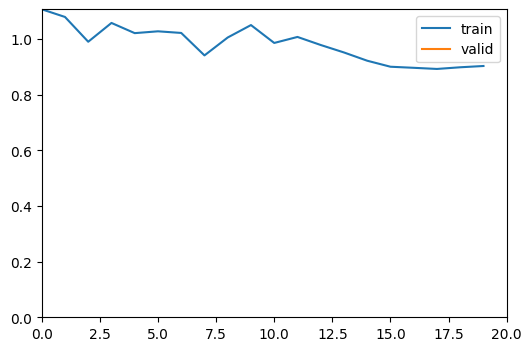

epoch,train_loss,valid_loss,mae,_rmse,mse,time
0,0.685369,0.621807,0.655699,0.788547,0.621807,00:19
1,0.682151,0.564335,0.571021,0.751222,0.564335,00:20
2,0.670804,0.636611,0.693607,0.797879,0.636611,00:21
3,0.643161,0.625919,0.651317,0.791151,0.625919,00:20
4,0.643527,0.491443,0.603300,0.701030,0.491443,00:24
5,0.632453,0.507622,0.565399,0.712476,0.507622,00:25
6,0.654667,0.767766,0.775964,0.876223,0.767766,00:26
7,0.651151,0.602086,0.654667,0.775942,0.602086,00:26
8,0.642264,0.611547,0.670940,0.782015,0.611547,00:26
9,0.654281,0.713991,0.679649,0.844980,0.713991,00:24


Better model found at epoch 0 with valid_loss value: 0.6218070983886719.


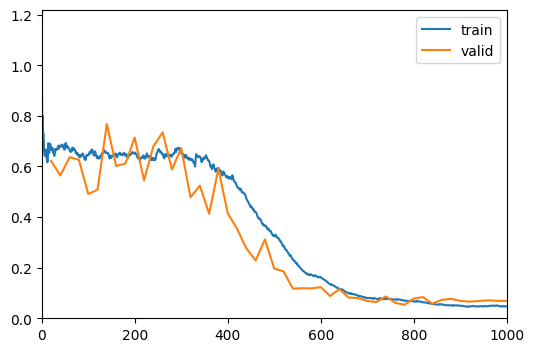

Better model found at epoch 1 with valid_loss value: 0.5643350481987.
Better model found at epoch 4 with valid_loss value: 0.49144282937049866.
Better model found at epoch 15 with valid_loss value: 0.47803258895874023.
Better model found at epoch 17 with valid_loss value: 0.41319507360458374.
Better model found at epoch 20 with valid_loss value: 0.3537709414958954.
Better model found at epoch 21 with valid_loss value: 0.2767801582813263.
Better model found at epoch 22 with valid_loss value: 0.2283330261707306.
Better model found at epoch 24 with valid_loss value: 0.19645273685455322.
Better model found at epoch 25 with valid_loss value: 0.18531839549541473.
Better model found at epoch 26 with valid_loss value: 0.11725548654794693.
Better model found at epoch 30 with valid_loss value: 0.08813829720020294.
Better model found at epoch 32 with valid_loss value: 0.0819469541311264.
Better model found at epoch 33 with valid_loss value: 0.07999968528747559.
Better model found at epoch 34 with

In [14]:
learn.fine_tune(50,base_lr=1e-4)

In [15]:
db = DataBlock(blocks = (ImageBlock, RegressionBlock()),
                 get_x=[ColReader('file',pref='wheat_all/')],
                 get_y=[ColReader('final yield (kg)')],
                 splitter=ColSplitter(col='dataset'),    
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=384,flip_vert=True,
                                            max_zoom=1.0), Normalize.from_stats(*imagenet_stats)])
dls = db.dataloaders(df,bs=8)

In [16]:
learn.dls=dls

In [17]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [18]:
preds,gt = learn.get_preds()

In [19]:
gt

tensor([-0.7456, -0.7456, -0.7456, -0.7456, -0.7456, -0.7456, -0.7456, -0.7456,
        -0.7456, -0.7456, -0.7456, -0.7456, -0.7456, -0.7456, -0.7456, -0.7456,
         1.5574,  1.5574,  1.5574,  1.5574,  1.5574,  1.5574,  1.5574,  1.5574,
         1.5574,  1.5574,  1.5574,  1.5574,  1.5574,  1.5574,  1.5574,  1.5574,
        -0.9144, -0.9144, -0.9144, -0.9144, -0.9144, -0.9144, -0.9144, -0.9144,
        -0.9144, -0.9144, -0.9144, -0.9144, -0.9144, -0.9144, -0.9144, -0.9144,
         0.6818,  0.6818,  0.6818,  0.6818,  0.6818,  0.6818,  0.6818,  0.6818,
         0.6818,  0.6818,  0.6818,  0.6818,  0.6818,  0.6818,  0.6818,  0.6818])

In [20]:
mean_absolute_error(gt*3.88292+5.30269,preds*3.88292+5.30269)

1.0964237

In [21]:
mean_squared_error(gt*3.88292+5.30269,preds*3.88292+5.30269)

1.7953122

In [22]:
math.sqrt(mean_squared_error(gt*3.88292+5.30269,preds*3.88292+5.30269))

1.3398925950291647